In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System
import os
import sys
sys.path.append('/home/helfrech/Tools/Toolbox/utils')

# Maths
import numpy as np
from numpy.random import default_rng
from sklearn.metrics import pairwise_distances

# Atoms
from ase.io import read
from ase.geometry import distance

# Utilities
from tools import load_json
import itertools
import h5py
import glob
import project_utils as utils
from tqdm.notebook import tqdm

# Plotting
import matplotlib.pyplot as plt

# SOAP
from soap import librascal_soap

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
color_list = cosmostyle.color_cycle
line_list = cosmostyle.linestyle_cycle

# Functions

In [3]:
def extract_volumes_and_numbers(structures, work_dir='.'):
    """
        Extracts and saves number of Si and volumes per Si
    """
    
    # Make required directories
    os.makedirs(work_dir, exist_ok=True)
        
    n_Si = np.zeros(len(structures), dtype=int)
    volumes = np.zeros(len(structures))
    
    # Iterate over structures and fill the property dictionary
    for sdx, structure in enumerate(structures):
        Z = structure.get_atomic_numbers()
        n_Si[sdx] = np.count_nonzero(Z == 14)
        volumes[sdx] = structure.cell.volume / n_Si[sdx]
        
    np.savetxt(f'{work_dir}/n_Si.dat', n_Si, fmt='%d')
    np.savetxt(f'{work_dir}/structure_volumes.dat', volumes, fmt='%.18e')

# Initial Setup

In [4]:
# Create root directories
os.makedirs('../Processed_Data', exist_ok=True)
os.makedirs('../Results/3.5', exist_ok=True)
os.makedirs('../Results/6.0', exist_ok=True)

# Extract Properties

## Deem

In [5]:
deem_330k = read('../Raw_Data/DEEM_330k/XYZ/DEEM_331172.xyz', index=':')

In [6]:
deem_10k_idxs = np.loadtxt('../Processed_Data/DEEM_330k/deem_10k.idxs', dtype=int)

In [7]:
# Extract volumes and number of Si
work_dir = '../Processed_Data/DEEM_330k/Data'
os.makedirs(work_dir, exist_ok=True)
extract_volumes_and_numbers(deem_330k, work_dir=work_dir)

# Copy over the energies for easy access
deem_energies = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary.dat', usecols=2)
np.savetxt(f'{work_dir}/structure_energies.dat', deem_energies)

## IZA

In [8]:
iza_230 = read('../Raw_Data/GULP/IZA_230/IZA_230.xyz', index=':')

In [9]:
# Extract volumes and number of Si
work_dir = '../Processed_Data/IZA_230/Data'
os.makedirs(work_dir, exist_ok=True)
extract_volumes_and_numbers(iza_230, work_dir=work_dir)

# Copy over the energies for easy access
iza_energies = np.loadtxt('../Raw_Data/GULP/IZA_230/optimization_summary_fix.dat', usecols=1)
np.savetxt(f'{work_dir}/structure_energies.dat', iza_energies)

# IZA Energy Histogram

In [10]:
iza_cantons = np.loadtxt('../Raw_Data/IZA_230/cantons.dat', usecols=1, dtype=int)
RWY = np.nonzero(iza_cantons == 4)[0][0]

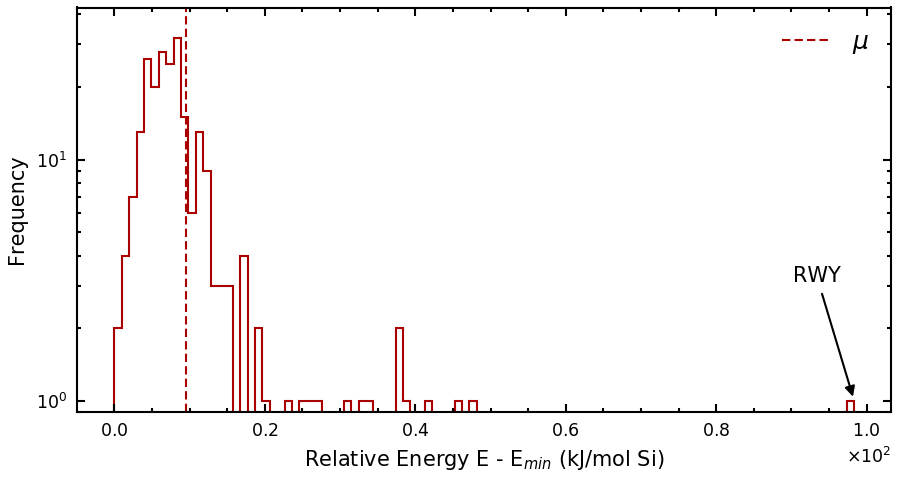

In [11]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

rel_iza_energies = iza_energies - np.amin(iza_energies)

axs.hist(
    rel_iza_energies,
    density=False, bins=100, log=True, color=color_list[1], histtype='step'
)
axs.axvline(np.mean(rel_iza_energies), color=color_list[1], label=r'$\mu$', linestyle='--')

axs.set_ylabel('Frequency')
axs.set_xlabel(r'Relative Energy E - E$_{min}$ (kJ/mol Si)')
axs.ticklabel_format(axis='x', style='sci', scilimits=(0, 0), useMathText=True)

axs.legend(fontsize='large')

annotate_params = dict(horizontalalignment='center', verticalalignment='bottom',
                       arrowprops=dict(arrowstyle='-|>'))

axs.annotate('RWY', (rel_iza_energies[RWY], 1),
            xytext=(rel_iza_energies[RWY]-5, 3),
            **annotate_params)

axs.set_ylim((0.9, axs.get_ylim()[1]))

fig.savefig('../Results/iza_energy_histogram.pdf', bbox_inches='tight')

plt.show()

# Check DEEM database energies vs. GULP shell-only optimization for the full 330k structures

In [12]:
gnorms = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary.dat', usecols=3)
failures = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary.dat', usecols=(4, 5), dtype=int)

In [13]:
# Failed structures
failed_idxs = np.nonzero(failures[:, 1])[0]
print(failed_idxs)

# Failed optimizations
failed_min_idxs = np.nonzero(failures[:, 0])[0]
print(failed_min_idxs)

[]
[    20    179    208    260   1062   1233   1244   1355   1587   1627
   1643   1976   2156   2170   2896   2962   3298   3316   3429   3927
   4069   5375   5435   5605   5637   6014   6048   7014   7436   7733
   7840   8862   9157   9219   9684   9999  10043  10069  10361  10475
  10503  10934  10937  10971  11301  11869  11980  12405  12464  12668
  12758  12781  13108  13564  13696  14518  14855  15193  15263  15329
  15346  15754  16764  16875  16967  17087  17640  17850  18069  18186
  18205  18530  18899  19277  19563  19775  19796  20019  20248  20653
  21158  21700  21859  22021  22105  22326  22354  22449  22986  23134
  23961  23971  24067  24090  24961  25163  25241  25803  26094  26174
  26526  26625  27020  28057  28450  28483  29243  29964  30336  30606
  30842  30994  31073  31317  31745  31748  31773  32110  32533  32574
  32825  32841  32900  33551  33555  33577  34125  34579  34598  34611
  34671  34684  34959  34990  35371  35463  35478  36127  36286  36549
  3

In [14]:
deem_energies = np.loadtxt('../Raw_Data/GULP/DEEM_330k/optimization_summary.dat', usecols=(1, 2))
errors_deem_energies = deem_energies[:, 1] - deem_energies[:, 0]
stdev_errors_deem_energies = np.std(errors_deem_energies)
mean_errors_deem_energies = np.mean(errors_deem_energies)

In [15]:
print(np.amax(errors_deem_energies), np.amin(errors_deem_energies))
print(np.amax(np.abs(errors_deem_energies)), np.amin(np.abs(errors_deem_energies)))
print(np.mean(np.abs(errors_deem_energies)), stdev_errors_deem_energies)
print(np.median(np.abs(errors_deem_energies)))

436.12611450000077 -1.8720523100000719
436.12611450000077 1.0019999535870738e-05
0.0779608267814896 0.8910860327112384
0.0737115800002357


In [16]:
np.sort(np.abs(errors_deem_energies))[::-1][0:50]

array([436.1261145 , 218.31865909, 154.31444258,  28.72319129,
        13.71595719,   5.33649231,   4.99306144,   4.45746786,
         3.76413334,   3.69750677,   2.8569973 ,   2.84775582,
         2.76586165,   2.58444828,   2.29685329,   2.19338452,
         2.10688081,   1.96386399,   1.90564323,   1.87205231,
         1.61384069,   1.58281975,   1.51017884,   1.49154737,
         1.48951941,   1.47800679,   1.44272234,   1.42296736,
         1.42016234,   1.41786602,   1.40724187,   1.34990108,
         1.33390725,   1.32730948,   1.326095  ,   1.32480914,
         1.29373519,   1.24559595,   1.22556197,   1.22416907,
         1.21561292,   1.21383734,   1.19853558,   1.19051007,
         1.18535411,   1.17747108,   1.17559588,   1.16706106,
         1.15040641,   1.14501854])

In [17]:
for i in range(1, 11):
    idx_high = np.nonzero(errors_deem_energies >=  mean_errors_deem_energies + i * stdev_errors_deem_energies)[0]
    idx_low = np.nonzero(errors_deem_energies <= mean_errors_deem_energies - i * stdev_errors_deem_energies)[0]
    idx_high += 8000001
    idx_low += 8000001
    idx_all = np.concatenate((idx_low, idx_high))
    n_in_deem_10k = np.intersect1d(deem_10k_idxs + 8000001, idx_all)
    print(f'{i}-sigma ({len(idx_all)}, {len(n_in_deem_10k)})')
    print(idx_all)

1-sigma (73, 1)
[8003901 8006729 8008584 8048539 8083141 8083319 8093500 8094930 8095091
 8112501 8116557 8150701 8005286 8018930 8026055 8033884 8038665 8045115
 8045207 8046146 8046372 8047419 8048144 8048319 8049127 8050069 8051910
 8054229 8056798 8060024 8060060 8060063 8065476 8068072 8070510 8070511
 8070513 8082701 8083696 8095801 8101419 8103559 8104277 8105084 8115895
 8116223 8116469 8118831 8119406 8120017 8120851 8121618 8122155 8126242
 8129573 8129961 8130896 8132587 8133950 8137397 8144390 8145575 8146026
 8150497 8153323 8154939 8162764 8162878 8164639 8166302 8265046 8326006
 8329346]
2-sigma (20, 0)
[8093500 8018930 8033884 8038665 8049127 8095801 8101419 8103559 8105084
 8115895 8119406 8126242 8129961 8130896 8133950 8154939 8162878 8265046
 8326006 8329346]
3-sigma (13, 0)
[8033884 8038665 8049127 8095801 8101419 8103559 8126242 8129961 8130896
 8154939 8265046 8326006 8329346]
4-sigma (10, 0)
[8038665 8049127 8095801 8101419 8103559 8126242 8130896 8265046 832600

In [18]:
error_limit = 10 # kJ/mol Si
deem_delete_idxs = np.nonzero(np.abs(errors_deem_energies) > error_limit)[0]
deem_delete_10k_idxs = np.intersect1d(deem_delete_idxs, deem_10k_idxs)
print(deem_delete_idxs)
print(deem_delete_10k_idxs)

np.savetxt(f'../Processed_Data/DEEM_330k/{error_limit}kJmol_error.idxs', deem_delete_idxs, fmt='%d')

[ 38664  95800 265045 326005 329345]
[]


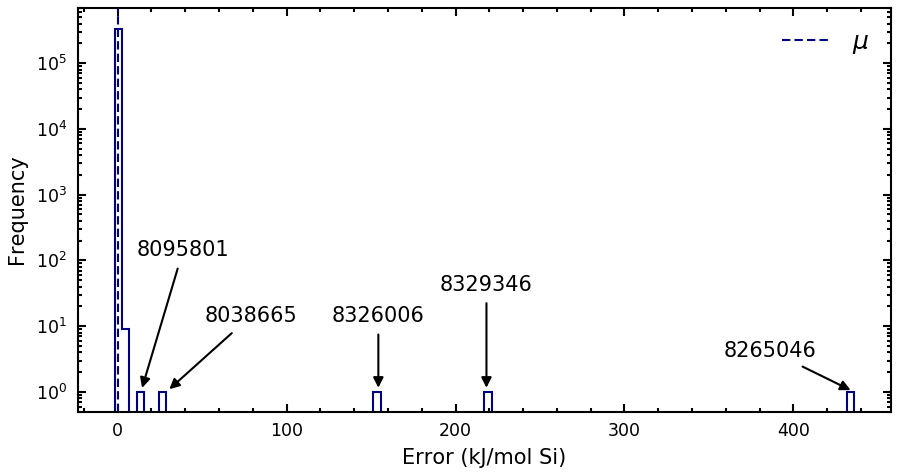

In [19]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

axs.hist(
    errors_deem_energies, 
    density=False, bins=100, log=True, color=color_list[2], histtype='step'
)

axs.axvline(mean_errors_deem_energies, color=color_list[2], label=r'$\mu$', linestyle='--')

axs.set_xlabel('Error (kJ/mol Si)')
axs.set_ylabel('Frequency')

axs.legend(fontsize='large')

annotate_params = dict(horizontalalignment='center', verticalalignment='bottom',
                       arrowprops=dict(arrowstyle='-|>'))

axs.annotate('8265046', (errors_deem_energies[265045], 1),
            xytext=(errors_deem_energies[265045]-50, 3),
            **annotate_params)
axs.annotate('8329346', (errors_deem_energies[329345], 1),
            xytext=(errors_deem_energies[329345], 30),
            **annotate_params)
axs.annotate('8326006', (errors_deem_energies[326005], 1),
            xytext=(errors_deem_energies[326005], 10),
            **annotate_params)
axs.annotate('8038665', (errors_deem_energies[38664], 1),
            xytext=(errors_deem_energies[38664]+50, 10),
            **annotate_params)
axs.annotate('8095801', (errors_deem_energies[95800], 1),
            xytext=(errors_deem_energies[95800]+25, 100),
            **annotate_params)

axs.set_ylim((0.5, axs.get_ylim()[1]))
             
fig.savefig('../Results/gulp_error_histogram.pdf', bbox_inches='tight')
    
plt.show()

# Check 10k SOAPs

In [20]:
# Load SOAP cutoffs
soap_hyperparameters = load_json('../Processed_Data/soap_hyperparameters.json')   
cutoffs = soap_hyperparameters['interaction_cutoff']

In [21]:
# Check that we can pull the correct SOAPs with the indices
for cutoff in cutoffs:
    for spectrum_label in ('power', 'radial'):
        
        # Manually load the 10k SOAPs, since they are environment based,
        # and therefore too large to fit in memory all at once
        dataset_10k = h5py.File(
            f'../Processed_Data/DEEM_10k/Data/{cutoff}/soaps_{spectrum_label}_full_nonorm.hdf5', 'r'
        )
        soaps_10k = []
        for dataset in tqdm(dataset_10k.values(), leave=False):
            soaps_10k.append(np.mean(dataset[:], axis=0))
            
        soaps_10k = np.vstack(soaps_10k)
        dataset_10k.close()

        soaps_330k = utils.load_hdf5(
            f'../Processed_Data/DEEM_330k/Data/{cutoff}/soaps_{spectrum_label}_full_avg_nonorm.hdf5',
            indices=deem_10k_idxs
        )

        print(np.allclose(soaps_10k, soaps_330k, rtol=1.0E-12, atol=1.0E-12))

True


True


True


True


# Find IZA in DEEM 330k

In [22]:
iza_labels = np.loadtxt('../Raw_Data/IZA_230/cantons.dat', usecols=0, dtype='3U')

In [23]:
deem_labels = np.arange(0, len(deem_330k)) + 8000001

In [24]:
# Load SOAPs: use 6.0 A power spectrum to determine identical frameworks
deem_soaps_file = h5py.File('../Processed_Data/DEEM_330k/Data/6.0/soaps_power_full_avg_nonorm.hdf5', 'r')
deem_soaps = deem_soaps_file['0']

iza_soaps = utils.load_hdf5('../Processed_Data/IZA_230/Data/6.0/soaps_power_full_avg_nonorm.hdf5')

batch_size = 10000
n_samples_330k = deem_soaps.len()
n_batches = n_samples_330k // batch_size
if n_samples_330k % batch_size > 0:
    n_batches += 1

D = np.zeros((n_samples_330k, len(iza_soaps)))
for i in tqdm(range(0, n_batches)):
    D[i * batch_size:(i + 1) * batch_size, :] = pairwise_distances(
        deem_soaps[i * batch_size:(i + 1) * batch_size, :], iza_soaps,
        metric='euclidean'
    )

deem_soaps_file.close()

utils.save_hdf5(
    '../Processed_Data/DEEM_330k/Data/6.0/deem-iza_distances.hdf5', D, 
    chunks=(1000, len(iza_soaps)), attrs=dict(distance_metric='euclidean')
)

logD = np.log10(D)
logDmin = np.log10(np.amin(D, axis=0))

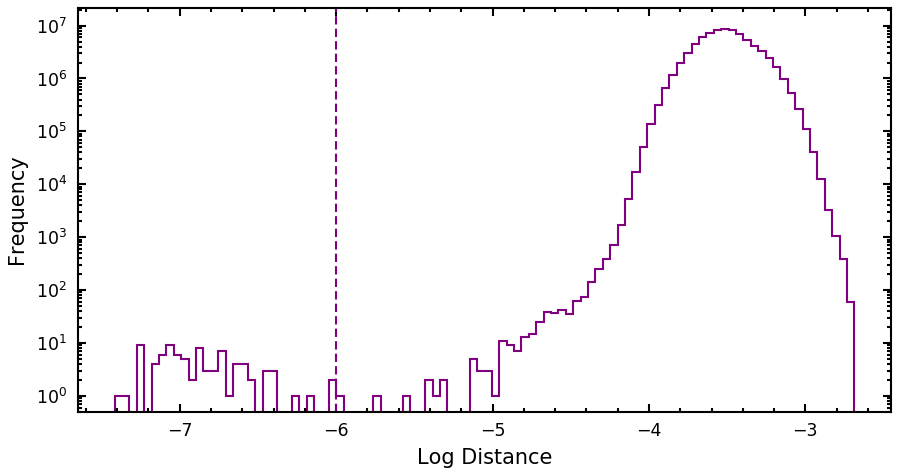

In [25]:
fig = plt.figure(figsize=(7.0, 3.5))
axs = fig.add_subplot(1, 1, 1)

axs.hist(
    logD.flatten(), 
    density=False, bins=100, log=True, color=color_list[4], histtype='step'
)
axs.axvline(-6, color=color_list[4], linestyle='--')

axs.set_xlabel('Log Distance')
axs.set_ylabel('Frequency')

axs.set_ylim((0.5, axs.get_ylim()[1]))

fig.savefig('../Results/6.0/similarity_histogram_6.0_power.pdf', bbox_inches='tight')
    
plt.show()

In [26]:
iza_in_deem_idxs, iza_idxs = np.nonzero(logD <= -6)
print(len(iza_idxs), len(iza_in_deem_idxs))

sort_idxs = np.argsort(iza_idxs)
print(np.column_stack((iza_labels[iza_idxs[sort_idxs]], deem_labels[iza_in_deem_idxs[sort_idxs]])))

np.savetxt('../Processed_Data/DEEM_330k/iza_in_deem.idxs', iza_in_deem_idxs, fmt='%d')

85 85
[['AEI' '8077977']
 ['AFN' '8125830']
 ['AFR' '8068316']
 ['AFS' '8323974']
 ['AFT' '8330864']
 ['AFV' '8321600']
 ['AFX' '8321918']
 ['AFY' '8054148']
 ['ANA' '8308045']
 ['ASV' '8307029']
 ['AVE' '8322677']
 ['AVL' '8321605']
 ['AWW' '8072989']
 ['BEC' '8067418']
 ['BOG' '8298667']
 ['BPH' '8327297']
 ['CHA' '8068050']
 ['DAC' '8115528']
 ['EAB' '8321606']
 ['EMT' '8325727']
 ['ERI' '8321602']
 ['ESV' '8252730']
 ['ETR' '8322713']
 ['ETV' '8036276']
 ['EZT' '8132964']
 ['FAU' '8307996']
 ['FER' '8115812']
 ['FRA' '8323748']
 ['GIS' '8000282']
 ['GME' '8077978']
 ['GON' '8166073']
 ['GOO' '8158586']
 ['HEU' '8094207']
 ['IFO' '8236886']
 ['IFR' '8038881']
 ['IFY' '8306634']
 ['ISV' '8316304']
 ['ITE' '8082737']
 ['IWR' '8060435']
 ['IWV' '8285528']
 ['JNT' '8125027']
 ['JSN' '8117232']
 ['KFI' '8307701']
 ['LEV' '8095118']
 ['LTJ' '8046159']
 ['LTL' '8322711']
 ['MAZ' '8323247']
 ['MEI' '8324829']
 ['MEL' '8311069']
 ['MOR' '8115524']
 ['MRT' '8119854']
 ['MSO' '8324148']
 ['NES

In [27]:
iza_in_deem_10k_idxs = np.intersect1d(iza_in_deem_idxs, deem_10k_idxs)
print(deem_labels[iza_in_deem_10k_idxs])

[8038881]


# Assign train and test sets

## Deem

One train and test set is used for the regression and PCA exercises, while a separate train and test set is used for the SVM and PCovR models

In [28]:
work_dir = '../Processed_Data/DEEM_330k'
n_total_deem = len(deem_330k)
idxs = np.arange(0, n_total_deem)

In [29]:
# Whole 10k set is used as the train set for ridge (relative to frame indices)
deem_ridge_train_delete_idxs = deem_delete_10k_idxs
deem_ridge_train_idxs = np.setdiff1d(deem_10k_idxs, deem_ridge_train_delete_idxs)
np.savetxt(f'{work_dir}/ridge_train.idxs', deem_ridge_train_idxs, fmt='%d')

# We choose 250 structures (excluding the 10k set and the "bad" frameworks) 
# from the 330k set to serve as the test set,
# roughly comparable with the size of IZA (relative to frame indices)
deem_ridge_test_delete_idxs = np.unique(np.concatenate(
    (deem_10k_idxs, deem_delete_idxs)
))
n_ridge_test = 250
rng = default_rng(seed=11011)
deem_ridge_test_idxs = np.delete(idxs, deem_ridge_test_delete_idxs)
rng.shuffle(deem_ridge_test_idxs)
deem_ridge_test_idxs = deem_ridge_test_idxs[0:n_ridge_test]
np.savetxt(f'{work_dir}/ridge_test.idxs', deem_ridge_test_idxs, fmt='%d')
    
# Random train and test sets for linear regression
n_ridge_train = len(deem_ridge_train_idxs)
rng = default_rng(seed=11011)
deem_ridge_idxs_random = np.delete(idxs, deem_delete_idxs)
rng.shuffle(deem_ridge_idxs_random)
deem_ridge_train_idxs_random = deem_ridge_idxs_random[0:n_ridge_train]
deem_ridge_test_idxs_random = deem_ridge_idxs_random[n_ridge_train:n_ridge_train + n_ridge_test]

np.savetxt(f'{work_dir}/ridge_train_random.idxs', deem_ridge_train_idxs_random, fmt='%d')
np.savetxt(f'{work_dir}/ridge_test_random.idxs', deem_ridge_test_idxs_random, fmt='%d')

In [34]:
print(len(deem_ridge_train_idxs), len(deem_ridge_test_idxs))
print(np.intersect1d(deem_ridge_train_idxs, deem_ridge_test_idxs))

print(len(deem_ridge_train_idxs_random), len(deem_ridge_test_idxs_random))
print(np.intersect1d(deem_ridge_train_idxs_random, deem_ridge_test_idxs_random))

10000 250
[]
10000 250
[]


In [30]:
# 10k set minus the "bad" Deem frameworks and the IZA-in-Deem frameworks
# is used as the train set for SVM and PCovR
deem_svm_train_delete_idxs = np.unique(np.concatenate(
    (iza_in_deem_10k_idxs, deem_delete_10k_idxs)
))
deem_svm_train_idxs = np.setdiff1d(deem_10k_idxs, deem_svm_train_delete_idxs)
np.savetxt(f'{work_dir}/svm_train.idxs', deem_svm_train_idxs, fmt='%d')

deem_svm_test_delete_idxs = np.unique(np.concatenate(
    (deem_10k_idxs, deem_delete_idxs, iza_in_deem_idxs)
))
deem_svm_test_idxs = np.delete(idxs, deem_svm_test_delete_idxs)
np.savetxt(f'{work_dir}/svm_test.idxs', deem_svm_test_idxs, fmt='%d')

In [35]:
print(len(deem_svm_train_idxs), len(deem_svm_test_idxs))
print(np.intersect1d(deem_svm_train_idxs, deem_svm_test_idxs))

9999 321083
[]


In [31]:
work_dir = '../Processed_Data/DEEM_330k/Data'

# Make Deem cantons for easy reference
np.savetxt(f'{work_dir}/cantons_2-class.dat', np.ones(n_total_deem, dtype=int) * 2, fmt='%d')
np.savetxt(f'{work_dir}/cantons_4-class.dat', np.ones(n_total_deem, dtype=int) * 4, fmt='%d')

# Make dummy Deem cantons to test the "null" case -- i.e.,
# the SVM shouldn't be able to predict a random split of Deem
rng = default_rng(seed=78651)
np.savetxt(f'{work_dir}/dummy_cantons_2-class.dat', rng.integers(1, 3, size=n_total_deem), fmt='%d')

rng = default_rng(seed=34251)
np.savetxt(f'{work_dir}/dummy_cantons_4-class.dat', rng.integers(1, 5, size=n_total_deem), fmt='%d')

## IZA

Train and test sets used just for the SVM and PCovR models, as the whole IZA is used as a test set for the regression exercise

In [32]:
work_dir = '../Processed_Data/IZA_230'
n_total_iza = len(iza_cantons)
idxs = np.arange(0, n_total_iza)

In [33]:
# We toss out RWY for both the train and test sets
iza_svm_idxs = np.delete(idxs, RWY)
rng = default_rng(seed=90909)
rng.shuffle(iza_svm_idxs)

# Train set (relative to frame indices)
n_svm_train = len(iza_svm_idxs) // 2
iza_svm_train_idxs = iza_svm_idxs[0:n_svm_train]
np.savetxt(f'{work_dir}/svm_train.idxs', iza_svm_train_idxs, fmt='%d')

# Test set (relative to frame indices)
iza_svm_test_idxs = iza_svm_idxs[n_svm_train:]
np.savetxt(f'{work_dir}/svm_test.idxs', iza_svm_test_idxs, fmt='%d')

In [39]:
print(len(iza_svm_train_idxs), len(iza_svm_test_idxs))
print(np.intersect1d(iza_svm_train_idxs, iza_svm_test_idxs))

114 115
[]
